In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import collections
import requests
import pickle
import json

## Protein Disorder Prediction

### Data set-up

Import drive, so that preprocessed data can be used in Notebook.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Quick access to preprocessed data, instead of downloading it each time Notebook is opened.

In [3]:
def read_sequences():
  with open('/content/drive/My Drive/Colab Notebooks/diss_files/sequence_data.json', 'r') as infile:
    return json.load(infile)

def read_cleaned_pandas_data():
  return pd.read_json('/content/drive/My Drive/Colab Notebooks/diss_files/idr_pandas_table.json')

def read_onehot():
  with open('/content/drive/My Drive/Colab Notebooks/diss_files/onehot_data.json', 'r') as infile:
    onehot_map = json.load(infile)
    onehot_map.update((acc, np.array(onehot)) for acc, onehot in onehot_map.items())
    return onehot_map

def read_pssms():
  with open('/content/drive/My Drive/Colab Notebooks/diss_files/pssm_data.json', 'r') as infile:
    pssm_map = json.load(infile)
    pssm_map.update((acc, np.array(pssm)) for acc, pssm in pssm_map.items())
    return pssm_map

def read_homo_solution():
  with open('/content/drive/My Drive/Colab Notebooks/diss_files/homo_solution.json', 'r') as infile:
    return json.load(infile)

# Protein sequences
protein_sequences_n_ids = read_sequences()
# IDRs
pandas_data_IDRs = read_cleaned_pandas_data()
# One-hot features
onehot_map = read_onehot()
# PSSM features
pssm_map = read_pssms()
# Randomly sampled dataset split from pre-processing.
# Data leakage prevention included.
non_leaking_dataset_split = read_homo_solution()

### Dataset class for our data. 
- Takes in pandas data (usually full TSV).
- The amino acid vectorising map.
- A dictionary mapping protein accession numbers to their sequence (generated from preprocessing).

In [4]:
class DisProtDataset(Dataset):
    def __init__(self, pandas_table, vector_map, protein_sequences, ids, transform=None):
        self.disorder_prot = pandas_table
        self.vectorised_seqs = vector_map
        self.sequences = protein_sequences
        self.ids = ids
        self.tranform = transform

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        # Protein accession number - key identifier
        acc = self.ids[idx]
        # Each row must have a unique accession number, hence we can 0 index this list
        dataframe_idx = self.disorder_prot.index[self.disorder_prot['acc'] == acc].tolist()[0]
        idrs = self.disorder_prot['disordered_regions'].loc[dataframe_idx]
        
        # Get vectorised sequence
        vectorised_protein_sequence = self.vectorised_seqs.get(acc)

        # Get protein sequence
        protein_sequence = self.sequences.get(acc)
        
        # Create order/disorder label
        disorder_label = np.zeros(len(protein_sequence))
        for (start, end) in idrs:
          disorder_label[start-1:end] = 1

        get_dict = {'acc': acc, 'seq': vectorised_protein_sequence, 'label': disorder_label}
        return get_dict

### Training model, given DisProt dataset

Separate train/validation/test datasets, with a 60/20/20 split.

One-hot feature encoding.

In [7]:
train_dataset = DisProtDataset(pandas_data_IDRs, onehot_map, protein_sequences_n_ids, non_leaking_dataset_split['Train'])
validation_dataset = DisProtDataset(pandas_data_IDRs, onehot_map, protein_sequences_n_ids, non_leaking_dataset_split['Validation'])
test_dataset = DisProtDataset(pandas_data_IDRs, onehot_map, protein_sequences_n_ids, non_leaking_dataset_split['Test'])

train_loader = DataLoader(train_dataset, batch_size=1,
                        shuffle=True, num_workers=0)

validation_loader = DataLoader(validation_dataset, batch_size=1,
                        shuffle=True, num_workers=0)

test_loader = DataLoader(test_dataset, batch_size=1,
                        shuffle=True, num_workers=0)

PSSM feature encoding.

In [8]:
train_pssm_dataset = DisProtDataset(pandas_data_IDRs, pssm_map, protein_sequences_n_ids, non_leaking_dataset_split['Train'])
validation_pssm_dataset = DisProtDataset(pandas_data_IDRs, pssm_map, protein_sequences_n_ids, non_leaking_dataset_split['Validation'])
test_pssm_dataset = DisProtDataset(pandas_data_IDRs, pssm_map, protein_sequences_n_ids, non_leaking_dataset_split['Test'])

train_pssm_loader = DataLoader(train_pssm_dataset, batch_size=1,
                        shuffle=True, num_workers=0)

validation_pssm_loader = DataLoader(validation_pssm_dataset, batch_size=1,
                        shuffle=True, num_workers=0)

test_pssm_loader = DataLoader(test_pssm_dataset, batch_size=1,
                        shuffle=True, num_workers=0)

### Working with a PyTorch NN. FCN model

In [9]:
class FCN_Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(20, 10, 21, padding=10)
        self.conv2 = nn.Conv1d(10, 10, 21, padding=10)
        self.conv3 = nn.Conv1d(10, 10, 21, padding=10)
        self.conv4 = nn.Conv1d(10, 10, 21, padding=10)
        self.conv5 = nn.Conv1d(10, 1, 21, padding=10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.conv5(x)
        # Removal of final activation function due to Logits Loss
        #x = torch.sigmoid(self.conv5(x))
        return x

### Evaluating with the Matthews correlation coefficient and the validation dataset each epoch.

MCC = $\frac{(TP * TN) - (FP * FN)}{\sqrt{(TP+FP)*(TP+FN)*(TN+FP)*(TN+FN)}}$

Where the variables are:
- TP - when a disordered protein is classified as disordered. A 1 is said to be a 1.
- FP - when an ordered protein is classified as disordered.   A 0 is said to be a 1.
- TN - when an ordered protein is classified as ordered.      A 0 is said to be a 0.
- FN - when an disordered protein is classified as ordered.   A 1 is said to be a 0.

In [10]:
# Turns the prediction to a list of ordered/disordered (0/1) predictions
def pred_round(predicted_label):
  predicted_label[predicted_label>=0.5] = 1
  predicted_label[predicted_label<0.5] = 0
  return predicted_label

def calc_MCC(predicted_label, true_label):
  # Calculating TN value
  # Sum as True values take on the value of 1
  TN = (true_label[predicted_label == 0] == 0).sum()
  # Calculating FN
  FN = (true_label[predicted_label == 0] == 1).sum()
  # Calculating TP
  TP = (true_label[predicted_label == 1] == 1).sum()
  # Calculating FP
  FP = (true_label[predicted_label == 1] == 0).sum()

  num = (TP * TN) - (FP * FN)
  den = torch.sqrt( (TP+FP)*(TP+FN)*(TN+FP)*(TN+FN) )
  if den == 0:
    return 0
  MCC = num / den
  return MCC

#### Counteracting the unbalanced dataset
- Generate a weight given the ratio of ordered to disordered amino acids.

In [11]:
def loss_weight_multiplier(loader):
  total_amino_acids = 0
  total_disordered_AA = 0
  for i, sam in enumerate(loader):
    lab = torch.squeeze(sam.get('label'))
    total_amino_acids += len(lab)
    total_disordered_AA += sum(lab)

  disordered_ratio = total_disordered_AA / total_amino_acids
  disordered_loss_weight = 1 / disordered_ratio
  return disordered_loss_weight

#### Using the Validation dataset
- Can monitor validation loss compared to training loss to prevent overfitting.
- This train and validation loop will give us results to plot the loss curves for the train and validation datasets per epoch.
- The MCC is also calculated on the validation set, given the model each epoch.

In [16]:
import datetime
epoch_print_gap = 20

def train_validation_loop_with_mcc(n_epochs, optimizer, model, loss_fn, train_loader, valid_loader, device):
    model = model.to(device)
    for epoch in range(0, n_epochs):
        
        running_loss_train = 0.0
        total_epoch_loss = 0.0

        # Creating an iterator jumbles the sequences order, so each accumulated batch will consider different 
        # sequences over many epochs
        train_iter = iter(train_loader)

        # Where i is a counter and sam is a dictionary
        for i, sam in enumerate(train_iter):
          acc, seq, label = sam.values()
          NN_input = seq.type(torch.FloatTensor)
          NN_input = NN_input.to(device)
          expected_output = label.type(torch.FloatTensor)
          expected_output = expected_output.to(device)

          output = model(NN_input)
          squeezed_o = torch.squeeze(output)
          squeezed_e_o = torch.squeeze(expected_output)

          loss = loss_fn(squeezed_o, squeezed_e_o)          
          loss.backward()
          running_loss_train += loss.item()
          total_epoch_loss += loss.item()

          # This has effect of batches of size 16.
          # Don't have just i as when i is 0, this is true, therefore use i+1 and divisor 17.
          if (i+1) % 17 == 0:
            optimizer.step()
            optimizer.zero_grad()
          
          # Print loss throughout epoch.
          # Shows loss per 400 sequences of each epoch.
          # Only prints on print gap
          if epoch % epoch_print_gap == 0:
            if (i+1) % 400 == 0:
              print("Epoch: "+str(epoch), end=" ")
              # Average loss over these 400 sequences
              print("Current loss: "+str(running_loss_train / 400))
              running_loss_train = 0.0
        
        # Validation data handling
        valid_iter = iter(valid_loader)
        total_loss_valid = 0
        total_MCC_valid = 0
        for i, sam in enumerate(valid_iter):
          acc, seq, label = sam.values()
          NN_input = seq.type(torch.FloatTensor)
          NN_input = NN_input.to(device)
          expected_output = label.type(torch.FloatTensor)
          expected_output = expected_output.to(device)

          with torch.no_grad():
            output = model(NN_input)
          squeezed_o = torch.squeeze(output)
          squeezed_e_o = torch.squeeze(expected_output)

          loss = loss_fn(squeezed_o, squeezed_e_o)          
          total_loss_valid += loss.item()

          total_MCC_valid += calc_MCC(pred_round(squeezed_o), squeezed_e_o)

        # Separates printed epochs
        if epoch == 0 or epoch % epoch_print_gap == 0:
            print("Epoch", epoch, "Done \n\n")

        epoch_loss_arr.append( (total_epoch_loss / len(train_loader)) )
        epoch_valid_loss_arr.append( (total_loss_valid / len(valid_loader)) )

        epoch_valid_MCC_arr.append( (total_MCC_valid / len(valid_loader)) )

# Main
lamb=0.001    # L2 weight decay term
lr = 0.001
epochs = 50
new_model = FCN_Net()
optimizer = optim.SGD(new_model.parameters(), lr=lr, momentum=0.9, weight_decay=lamb)
use_cuda = True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
disordered_loss_weight = loss_weight_multiplier(train_loader)
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=disordered_loss_weight.to(device))

epoch_loss_arr = []
epoch_valid_loss_arr = []
epoch_valid_MCC_arr = []
train_validation_loop_with_mcc(epochs, optimizer, new_model, criterion, train_loader, validation_loader, device)


Epoch: 0 Current loss: 1.5202690249681472
Epoch: 0 Current loss: 1.4620384778082371
Epoch: 0 Current loss: 1.3517720675468445
Epoch 0 Done 


Epoch: 20 Current loss: 1.1025419007241726
Epoch: 20 Current loss: 1.1369364938884974
Epoch: 20 Current loss: 1.1278981374949217
Epoch 20 Done 


Epoch: 40 Current loss: 1.0016104650497437
Epoch: 40 Current loss: 0.9699544115737081
Epoch: 40 Current loss: 1.0230949349328875
Epoch 40 Done 




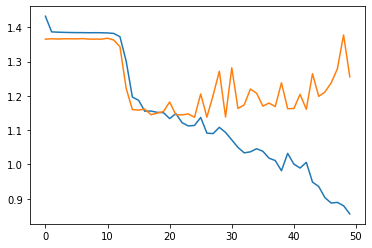

In [17]:
#epoch_valid_MCC_arr_plottable = [epoch_valid_MCC_arr[i].to('cpu').numpy() if epoch_valid_MCC_arr[i] != 0 else 0.0 for i, se in enumerate(epoch_valid_MCC_arr)]

plt.plot(range(50), epoch_loss_arr)
plt.plot(range(50), epoch_valid_loss_arr)
#plt.plot(range(50), epoch_valid_MCC_arr_plottable)
plt.show()

Evaluating MCC over entire test dataset.

In [20]:
def calculate_dataset_mcc(name, dataset):
  test_mcc_score = 0

  for seq in dataset:
    input_seq = seq.get('seq')
    input_seq = input_seq.type(torch.FloatTensor)
    input_seq = input_seq.to(device)
    true_label = seq.get('label')
    true_label = true_label.type(torch.FloatTensor)
    true_label = true_label.to(device)

    with torch.no_grad():
      predicted_label = new_model(input_seq)

    predicted_label = torch.sigmoid(predicted_label)
    predicted_label = torch.squeeze(predicted_label)
    true_label = torch.squeeze(true_label)

    pred_lab = pred_round(predicted_label)
    test_mcc_score += calc_MCC(pred_lab, true_label)

  print(name+" MCC score: ", ( test_mcc_score / len(dataset) ))

In [22]:
calculate_dataset_mcc("Test", test_loader)

### Saving model - for later use.

In [ ]:
# Writes trained model to storage
def write_model(model):

  model = model.to("cpu")
  PATH = '/content/drive/My Drive/Colab Notebooks/diss_files/1D_cnn_net.pth'
  torch.save(model.state_dict(), PATH)

write_model(new_model)